In [1]:
import warnings
import gc

warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, matthews_corrcoef

from catboost import CatBoostClassifier

import numpy as np

In [2]:
RAND = 2137

In [3]:
X_train = pd.read_parquet('/kaggle/input/ps4e8-data-eng/train.parquet', engine='pyarrow')
y_train = X_train.pop('class')

X_test = pd.read_parquet('/kaggle/input/ps4e8-data-eng/test.parquet', engine='pyarrow')
y_test = X_test.pop('class')

X_val = pd.read_parquet('/kaggle/input/ps4e8-data-eng/val.parquet', engine='pyarrow')
assert 'class' not in X_val.columns

X_train

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
942383,9.740,1,1,5,1,6,-1,4,8.210,18.020,-1,-1,2,-1,1,1,3,-1,0,0
471675,3.890,3,4,5,0,1,0,6,5.760,4.390,-1,6,8,-1,-1,0,0,-1,5,2
2860113,1.390,1,6,7,0,3,-1,0,5.490,1.530,-1,2,3,-1,-1,0,0,-1,0,0
130904,4.290,1,0,6,0,0,0,10,5.210,6.840,-1,-1,1,-1,-1,0,0,-1,5,2
3153311,3.180,3,0,7,0,-1,0,4,7.350,7.860,-1,-1,3,0,1,1,1,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931091,6.260,6,-1,5,0,3,0,0,5.390,8.490,-1,1,0,-1,-1,0,0,-1,3,0
1973814,7.780,4,-1,5,0,-1,-1,0,3.900,21.490,-1,-1,2,-1,-1,0,0,-1,0,2
2044748,6.620,1,1,5,0,1,0,0,5.910,6.500,-1,0,2,-1,-1,1,6,-1,0,2


In [4]:
y_train

id
942383     0
471675     1
2860113    0
130904     0
3153311    1
          ..
1931091    0
1973814    0
2044748    0
2324499    0
2654149    1
Name: class, Length: 2542411, dtype: int64

In [5]:
X_val

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
3116945,8.640,1,-1,5,1,-1,-1,0,11.130,17.120,0,-1,0,0,1,1,5,-1,0,0
3116946,6.900,4,4,1,0,-1,0,4,1.270,10.750,-1,-1,2,-1,-1,0,0,-1,0,0
3116947,2.000,3,6,5,0,-1,0,1,6.180,3.140,-1,-1,2,-1,-1,0,0,-1,0,3
3116948,3.470,1,4,5,0,2,0,1,4.980,8.510,-1,-1,0,-1,0,1,1,-1,0,2
3116949,6.170,1,1,7,0,6,-1,4,6.730,13.700,-1,-1,3,-1,3,1,-1,-1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194904,0.880,1,6,4,0,0,1,0,2.670,1.350,-1,-1,4,-1,-1,0,0,-1,0,2
5194905,3.120,1,0,4,0,3,0,0,2.690,7.380,-1,-1,0,-1,-1,0,0,-1,2,0
5194906,5.730,1,5,6,0,0,-1,0,6.160,9.740,-1,-1,3,-1,1,1,1,-1,0,0


In [6]:
X_val.shape

(2077964, 20)

In [7]:
train_cols = X_train.columns
train_cols

Index(['cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')

In [8]:
X_train.dtypes

cap-diameter            float64
cap-shape                 int64
cap-surface               int64
cap-color                 int64
does-bruise-or-bleed      int64
gill-attachment           int64
gill-spacing              int64
gill-color                int64
stem-height             float64
stem-width              float64
stem-root                 int64
stem-surface              int64
stem-color                int64
veil-type                 int64
veil-color                int64
has-ring                  int64
ring-type                 int64
spore-print-color         int64
habitat                   int64
season                    int64
dtype: object

In [9]:
ratio = (y_train.shape[0]-y_train.sum())/y_train.sum()  # sum_neg/sum_pos
ratio

0.8271968274296819

In [10]:
y_train.value_counts()

class
1    1391427
0    1150984
Name: count, dtype: int64

In [11]:
cat_fts = list(set(X_train.columns) - set(['cap-diameter', 'stem-height', 'stem-width']))
cat_fts

['stem-surface',
 'veil-type',
 'spore-print-color',
 'gill-attachment',
 'cap-color',
 'gill-color',
 'ring-type',
 'season',
 'cap-shape',
 'stem-color',
 'stem-root',
 'cap-surface',
 'has-ring',
 'habitat',
 'veil-color',
 'does-bruise-or-bleed',
 'gill-spacing']

In [12]:
for ft in cat_fts:
    X_train[ft] = X_train[ft].astype(str)
    X_test[ft] = X_test[ft].astype(str)
    X_val[ft] = X_val[ft].astype(str)

In [13]:
X_train.dtypes

cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
dtype: object

In [14]:
params = {
    'iterations': 99999999,
    'eval_metric': 'MCC',
    'learning_rate': 0.01,
    'task_type': 'GPU'
    #'depth': 9,
    #'l2_leaf_reg': 55.37964307854247,
    #'max_bin': 404,
    #'bagging_temperature': 0.017138393608280057,
    #'random_strength': 9.256288011643901
}

In [15]:
model = CatBoostClassifier(
    early_stopping_rounds=300,
    verbose=1,
    random_state=RAND,
    allow_writing_files=False,
    cat_features=cat_fts,
    **params
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

0:	learn: 0.5942799	test: 0.5960363	best: 0.5960363 (0)	total: 4.49s	remaining: 5201d 7h 58m 45s
1:	learn: 0.7754740	test: 0.7788057	best: 0.7788057 (1)	total: 4.79s	remaining: 2772d 8h 11m 34s
2:	learn: 0.7984548	test: 0.7999247	best: 0.7999247 (2)	total: 5.09s	remaining: 1963d 13h 31m 47s
3:	learn: 0.7964815	test: 0.7991037	best: 0.7999247 (2)	total: 5.34s	remaining: 1543d 23h 43m 28s
4:	learn: 0.7837659	test: 0.7855520	best: 0.7999247 (2)	total: 5.63s	remaining: 1304d 5h 50m 50s
5:	learn: 0.7878192	test: 0.7914126	best: 0.7999247 (2)	total: 5.94s	remaining: 1146d 2h 24m 58s
6:	learn: 0.7874434	test: 0.7910675	best: 0.7999247 (2)	total: 6.18s	remaining: 1022d 5h 40m 57s
7:	learn: 0.7883050	test: 0.7938268	best: 0.7999247 (2)	total: 6.42s	remaining: 928d 6h 2m 33s
8:	learn: 0.7684387	test: 0.7755269	best: 0.7999247 (2)	total: 6.66s	remaining: 856d 18h 24m 59s
9:	learn: 0.7634413	test: 0.7661442	best: 0.7999247 (2)	total: 6.9s	remaining: 798d 23h 58m 40s
10:	learn: 0.7681195	test: 0.77

In [16]:
print(f"Score {matthews_corrcoef(y_test, model.predict(X_test))}")

Score 0.9847102497456705


In [17]:
pd.DataFrame(confusion_matrix(y_test, model.predict(X_test)))

,0,1
0,285626,2120
1,2697,345160


In [18]:
def get_prob(X_test):
    df = pd.DataFrame(model.predict_proba(X_test), columns=['0', '1'])
    return df['1']

In [19]:
X_val

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
id,,,,,,,,,,,,,,,,,,,,
3116945,8.640,1,-1,5,1,-1,-1,0,11.130,17.120,0,-1,0,0,1,1,5,-1,0,0
3116946,6.900,4,4,1,0,-1,0,4,1.270,10.750,-1,-1,2,-1,-1,0,0,-1,0,0
3116947,2.000,3,6,5,0,-1,0,1,6.180,3.140,-1,-1,2,-1,-1,0,0,-1,0,3
3116948,3.470,1,4,5,0,2,0,1,4.980,8.510,-1,-1,0,-1,0,1,1,-1,0,2
3116949,6.170,1,1,7,0,6,-1,4,6.730,13.700,-1,-1,3,-1,3,1,-1,-1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194904,0.880,1,6,4,0,0,1,0,2.670,1.350,-1,-1,4,-1,-1,0,0,-1,0,2
5194905,3.120,1,0,4,0,3,0,0,2.690,7.380,-1,-1,0,-1,-1,0,0,-1,2,0
5194906,5.730,1,5,6,0,0,-1,0,6.160,9.740,-1,-1,3,-1,1,1,1,-1,0,0


In [20]:
prd = pd.DataFrame({"class" : model.predict(X_val[train_cols]), "id" : X_val.index}).set_index('id')
prd

,class
id,
3116945,0
3116946,1
3116947,1
3116948,1
3116949,0
...,...
5194904,1
5194905,1
5194906,1


In [21]:
prd = prd.replace({0: 'e', 1: 'p'})

In [22]:
prd.to_csv('submission.csv', index=True)
sub = pd.read_csv('submission.csv', index_col='id')

assert sub.shape[0] == 2077964
sub.head()

,class
id,
3116945,e
3116946,p
3116947,p
3116948,p
3116949,e


In [23]:
print("Sub file done!")

Sub file done!


In [24]:
prd = pd.DataFrame({"cat": get_prob(X_train), "id": X_train.index}).set_index('id')
prd.to_parquet('cattrain_pred.parquet', index=True)
prd.head()

,cat
id,
942383,0.001
471675,1.000
2860113,0.005
130904,0.014
3153311,1.000


In [25]:
print("Train file done!")

Train file done!


In [26]:
prd = pd.DataFrame({"cat": get_prob(X_test), "id": X_test.index}).set_index('id')
prd.to_parquet('cattest_pred.parquet', index=True)
prd.head()

,cat
id,
1124443,0.998
871557,0.990
669155,0.993
1219975,0.002
2715204,0.997


In [27]:
print("Test file done!")

Test file done!


In [28]:
prd = pd.DataFrame({"cat": get_prob(X_val), "id": X_val.index}).set_index('id')
prd.to_parquet('catval_pred.parquet', index=True)
prd.head()

,cat
id,
3116945,0.003
3116946,0.998
3116947,0.987
3116948,0.996
3116949,0.003


In [29]:
print("Val file done!")

Val file done!


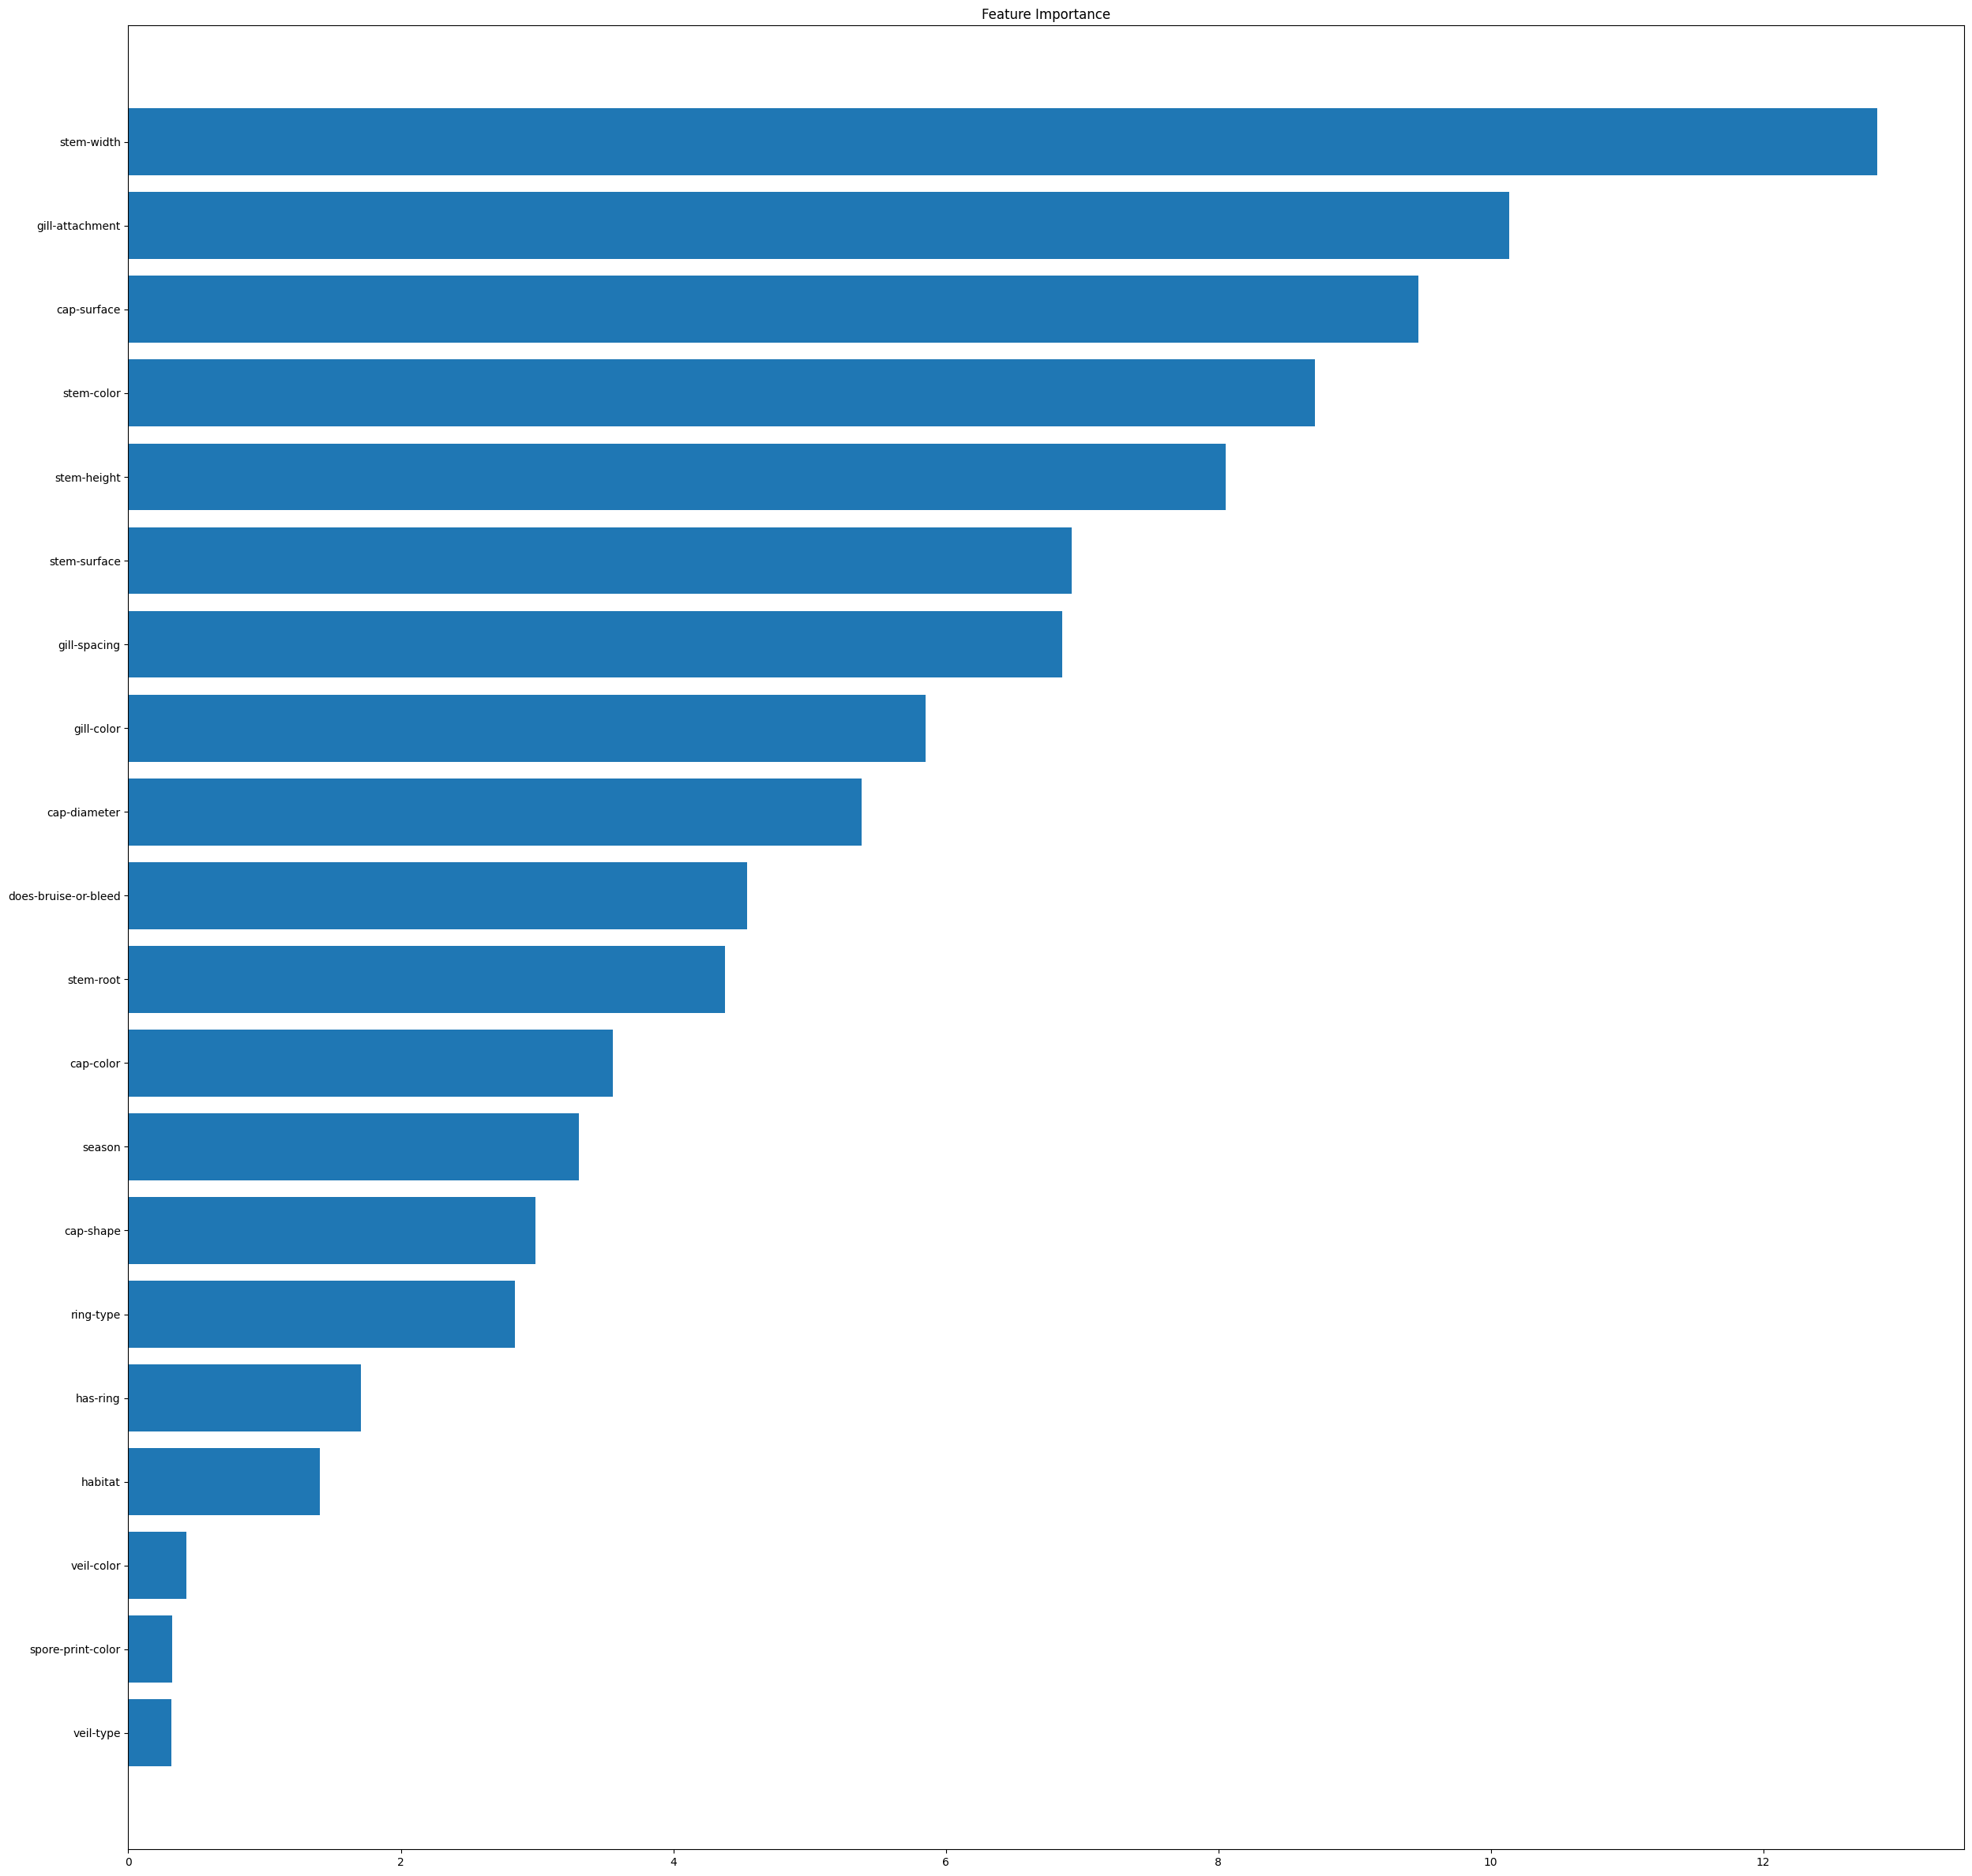

In [30]:
imps = model.feature_importances_
sorted_idx = np.argsort(imps)
plt.figure(figsize=(30, 30))
plt.barh(range(len(sorted_idx)), imps[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

<Axes: xlabel='1', ylabel='Count'>

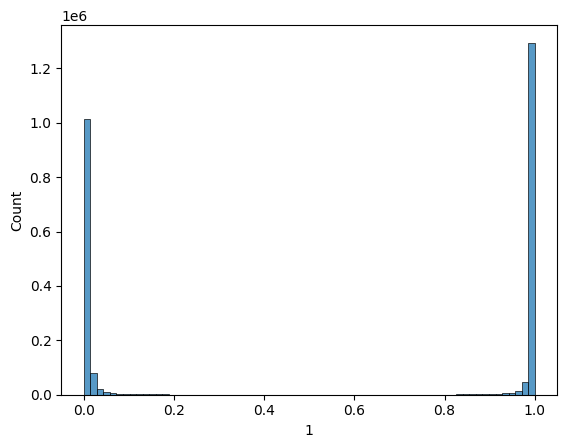

In [31]:
sns.histplot(get_prob(X_train))

<Axes: xlabel='1', ylabel='Count'>

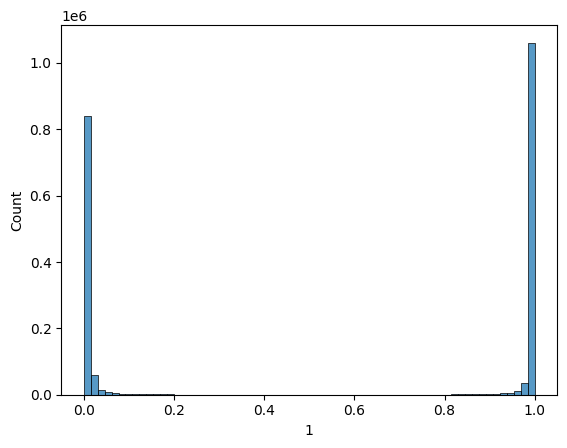

In [32]:
sns.histplot(get_prob(X_val))

<Axes: xlabel='1', ylabel='Count'>

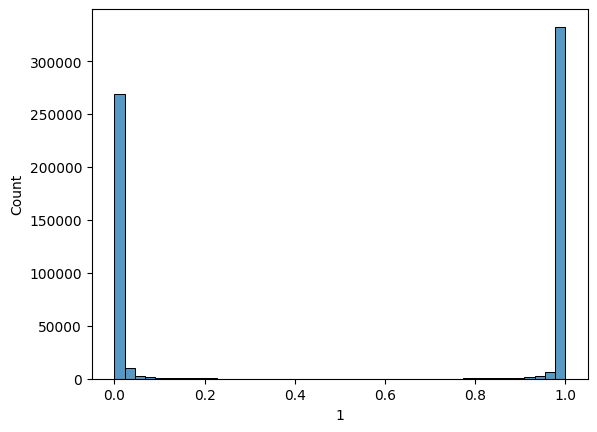

In [33]:
sns.histplot(get_prob(X_test))

In [34]:
prd = model.predict(X_val)
print(f"#1% {prd.sum()/prd.shape[0]}")

#1% 0.5455017507521785
